# Watch your tail!

Allen Downey 2019

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

from utils import decorate

Loading historical data from the S&P 500:

In [2]:
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=-630961200&period2=1565150400&interval=1d&filter=history&frequency=1d

df = pd.read_csv('yahoo/yahoo_sp500.csv', index_col=0, parse_dates=True)
df.shape

(17511, 6)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000


In [4]:
change = df['Open'].diff() / df['Open'] * 100
change = change.shift(-1).dropna()
change.shape

(17510,)

In [5]:
change.head()

Date
1950-01-03    1.127596
1950-01-04    0.472534
1950-01-05    0.294464
1950-01-06    0.585480
1950-01-09   -0.293594
Name: Open, dtype: float64

In [6]:
change.tail()

Date
2019-07-30    0.283801
2019-07-31   -1.204565
2019-08-01   -1.237140
2019-08-02   -1.581392
2019-08-05   -1.289333
Name: Open, dtype: float64

[One day rally after the 2008 crash](https://money.cnn.com/2008/10/28/markets/markets_newyork/index.htm)

In [7]:
change.max(), change.idxmax()

(9.642263098399555, Timestamp('2008-10-28 00:00:00'))

[Black Monday](https://en.wikipedia.org/wiki/Black_Monday_(1987))

In [8]:
change.min(), change.idxmin()

(-25.610954639749, Timestamp('1987-10-19 00:00:00'))

In [9]:
change['2008-10-29']

-0.013839447221347778

In [10]:
df.loc['2008-10-29']

Open         9.395100e+02
High         9.699700e+02
Low          9.222600e+02
Close        9.300900e+02
Adj Close    9.300900e+02
Volume       7.077800e+09
Name: 2008-10-29 00:00:00, dtype: float64

In [11]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(change)

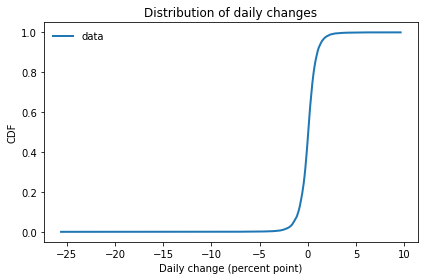

In [12]:
cdf.plot(label='data')
decorate(xlabel='Daily change (percent point)',
         ylabel='CDF',
         title='Distribution of daily changes')

To compare data to a distribution, I like to look at CDFs

In [13]:
from scipy.stats import norm

def make_model(sample, size=201):
    """Estimate the parameters of a Gaussian model.
    """
    mu = np.mean(sample)
    sigma = np.std(sample)
    model = norm(mu, sigma)

    xs = np.linspace(np.min(sample), np.max(sample), size)
    ys = model.cdf(xs)
    return xs, ys

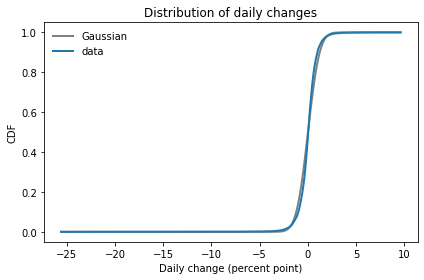

In [14]:
xs, ys = make_model(change)

plt.plot(xs, ys, color='gray', label='Gaussian')
cdf.plot(label='data')
decorate(xlabel='Daily change (percent point)',
         ylabel='CDF',
         title='Distribution of daily changes')

In [15]:
def plot_middle(sample):
    """Plot the CDF between -3 and 3 percentage points.
    """
    xs, ys = make_model(sample)
    plt.plot(xs, ys, color='gray', label='Gaussian')
    
    cdf = Cdf.from_seq(sample)
    cdf.plot(label='data')
    
    decorate(xlim=[-3, 3],
         xlabel='Daily change (percent point)',
         ylabel='CDF',
         title='Distribution of daily changes')

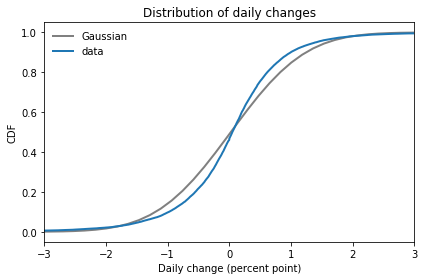

In [16]:
plot_middle(change)

In [17]:
def make_normal_prob_plot(sample):
    """Plot a normal probablity plot.
    """
    xs = norm.rvs(size=len(sample))
    xs = np.sort(xs)
    ys = np.sort(sample)
    
    span = min(xs), max(xs)
    plt.plot(span, span, color='gray', alpha=0.5)
    plt.plot(xs, ys)
    
    decorate(xlabel='Standard deviations from the mean',
             ylabel='Daily change (percent point)',
             title='Normal probability plot')

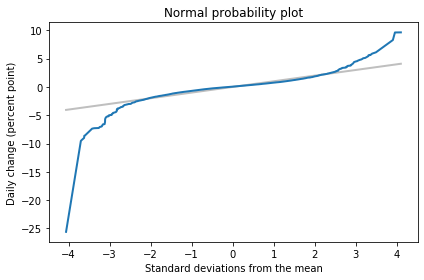

In [18]:
make_normal_prob_plot(change)

In [19]:
from empiricaldist import Surv

def tail_plot(sample):
    """Plot the CCDF on a log-log scale.
    """
    xs, ys = make_model(sample)
    plt.plot(xs, 1-ys, color='gray', label='Gaussian')

    # when we plot y on a log scale, we lose the
    # most extreme value
    surv = Surv.from_seq(sample)
    surv.replace(0, np.nan, inplace=True)
    surv.plot(label='data')
    
    decorate(xscale='log', 
             yscale='log',
             xlabel='Daily change (percent point)',
             ylabel='CCDF (log)')
    
    return surv

In [20]:
def resample(sample, ncols=101):
    """Generate bootstrap samples.
    """
    nrows = len(sample)
    array = np.random.choice(sample, (nrows, ncols))
    return pd.DataFrame(array)

In [21]:
def plot_surv_confidence(index, samples, **options):
    """Plot a 90% confidence interval for a survival curve.
    """
    df = pd.DataFrame(index=index, columns=samples.columns)
    for i in samples.columns:
        surv = Surv.from_seq(samples[i])
        surv.replace(0, np.nan, inplace=True)
        df[i] = surv(index)
    
    df.fillna(method='ffill', inplace=True)
    df.values.sort()
    
    nrows, ncols = df.shape
    low = int(ncols * 0.05)
    high = int(ncols * 0.95)
    plt.fill_between(df.index, df[low], df[high], **options)

In [22]:
from matplotlib.ticker import NullFormatter

def set_xticks(locs, labels):
    """Put tick labels at the given locations.
    """
    ax = plt.gca()
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    plt.xticks(locs, labels)

In [23]:
def plot_right(sample):
    """Plot the right tail.
    """
    shift = np.min(sample)
    right_tail = sample - shift

    surv = tail_plot(right_tail)

    samples = resample(right_tail, 101)
    plot_surv_confidence(surv.index, samples, alpha=0.2)

    decorate(title='Right tail of daily changes',
             xlim=[20, 40],
             ylim=[1e-5, 1.5])

    labels = np.array([1, 3, 5, 7, 10])
    locs = labels - shift
    set_xticks(locs, labels)
    
    return surv

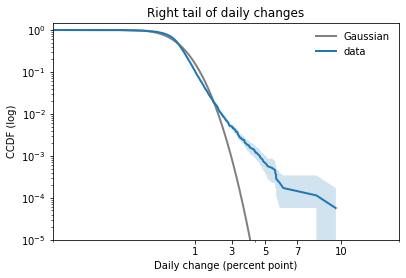

In [24]:
plot_right(change);

In [25]:
def plot_left(sample):
    """Plot the left tail.
    """
    shift = np.max(sample)
    left_tail = shift - sample

    surv = tail_plot(left_tail)

    samples = resample(left_tail, 101)
    plot_surv_confidence(surv.index, samples, alpha=0.2)

    decorate(title='Left tail of daily changes', 
         xlim=[7, 22],
         ylim=[1e-5, 1.5])

    plt.gca().invert_xaxis()

    labels = np.array([-1, -3, -5, -7, -10])
    locs = shift - labels
    set_xticks(locs, labels)
    
    return surv

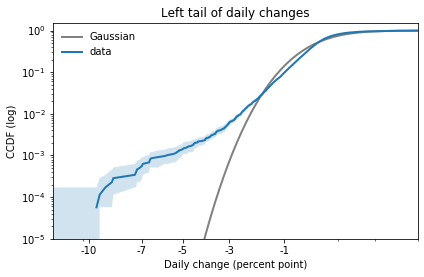

In [26]:
plot_left(change);

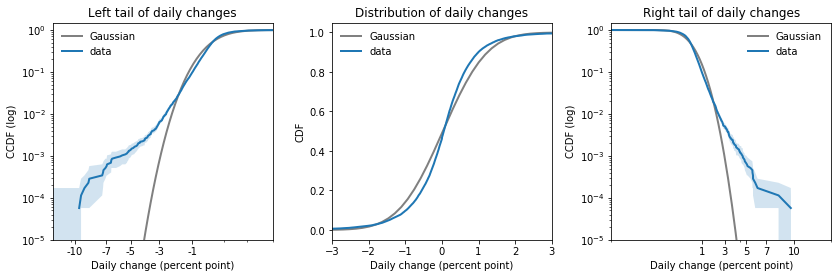

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plot_left(change)

plt.subplot(1, 3, 2)
plot_middle(change)

plt.subplot(1, 3, 3)
plot_right(change)

plt.savefig('sp550.1.png', dpi=150)

Bayesian analysis adapted from 
https://towardsdatascience.com/bayesian-modeling-airlines-customer-service-twitter-response-time-74af893f02c0

In [28]:
import pymc3 as pm

# Normal model
with pm.Model() as model:
    μ = pm.Uniform('μ', lower=0, upper=10)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=change)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1883.63draws/s]


In [29]:
import pymc3 as pm

# Student T model
with pm.Model() as model:
    μ = pm.Uniform('μ', lower=0, upper=60)
    s = pm.HalfNormal('s', sd=10)
    ν = pm.Exponential('ν', 1/1)
    y = pm.StudentT('y', mu=μ, sd=s, nu=ν, observed=change)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, s, μ]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:16<00:00, 491.00draws/s]


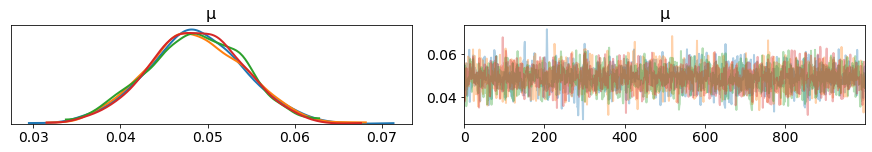

In [30]:
import arviz as az

az.plot_trace(trace[:1000], var_names = ['μ']);

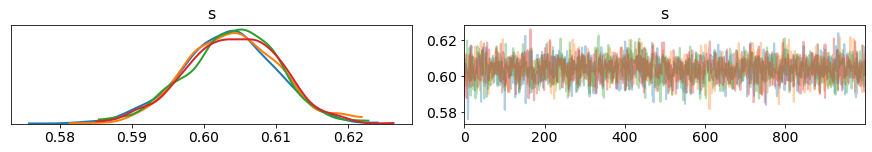

In [31]:
az.plot_trace(trace[:1000], var_names = ['s']);

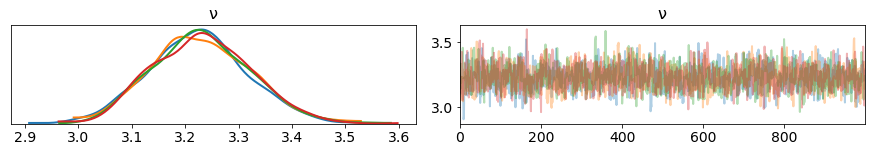

In [32]:
az.plot_trace(trace[:1000], var_names = ['ν']);

In [33]:
ppc = pm.sample_posterior_predictive(trace, samples=101, model=model)

100%|██████████| 101/101 [00:00<00:00, 348.36it/s]


In [34]:
samples = pd.DataFrame(np.transpose(ppc['y']))
samples.shape

(17510, 101)

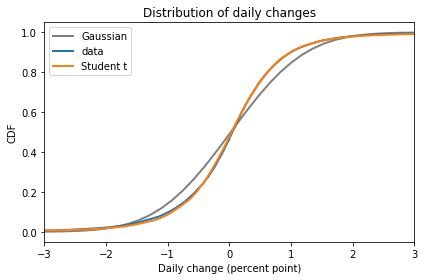

In [35]:
plot_middle(change)
cdf_y = Cdf.from_seq(samples[0])
cdf_y.plot(label='Student t')
plt.legend();

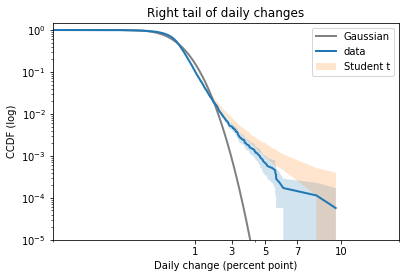

In [36]:
surv = plot_right(change)

shift = np.min(change)
right_samples = pd.DataFrame(np.transpose(ppc['y'])) - shift
plot_surv_confidence(surv.index, right_samples, 
                     alpha=0.2, 
                     label='Student t')
plt.legend();

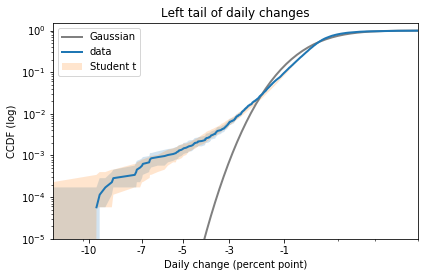

In [37]:
surv = plot_left(change)

shift = np.max(change)
left_samples = shift - pd.DataFrame(np.transpose(ppc['y']))
plot_surv_confidence(surv.index, left_samples, 
                     alpha=0.2, 
                     label='Student t')
plt.legend();

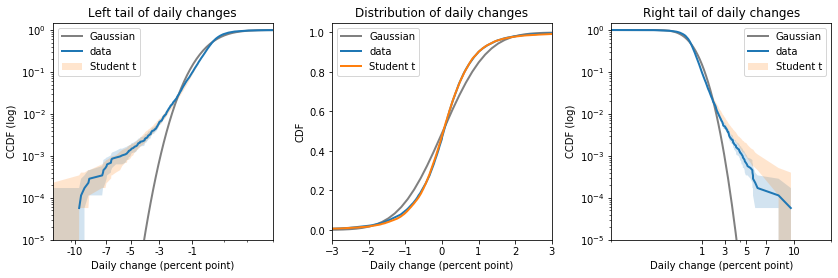

In [38]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
surv = plot_left(change)
plot_surv_confidence(surv.index, left_samples, 
                     alpha=0.2, 
                     label='Student t')
plt.legend()

plt.subplot(1, 3, 2)
plot_middle(change)
cdf_y.plot(label='Student t')
plt.legend()

plt.subplot(1, 3, 3)
surv = plot_right(change)
plot_surv_confidence(surv.index, right_samples, 
                     alpha=0.2, 
                     label='Student t')
plt.legend()

plt.savefig('sp550.2.png', dpi=150)